In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from pathlib import Path
ROOT = Path('/content/drive/MyDrive/universite-paris-saclay/nlp/rottentomatoes')

In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 101.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 110.5 MB/s eta 0:00:00


In [4]:
from pathlib import Path
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
from wordcloud import WordCloud
from transformers import BertModel, BertTokenizer
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


import matplotlib.pyplot as plt
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import nltk
import gensim
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [6]:
RANDOM_STATE = 2023

TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2

In [7]:
# Create a function to tokenize a set of texts
def preprocessing_for_bert(data, max_len):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text = sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=max_len,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

TASKS:
- Classification (binary: [Rotten/Fresh])
- Regression: [0-5]

-----

# CLASSIFICATION

In [8]:
# REGRESSION

In [15]:
reviews_df = pd.read_csv(ROOT / "preprocessed_reviews.csv")

# Sample just a portion of the data
# perc = 0.99
# reviews_df = reviews_df.sample(frac=perc, random_state=RANDOM_STATE)

X = reviews_df['review_content'].values
y = reviews_df['review_type'].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

X_train, X_val, y_train, y_val =\
    train_test_split(X_train, y_train, test_size=VALIDATION_SIZE, random_state=RANDOM_STATE)

# Tokenize the input text

# From the histogram we saw that all the reviews
# are shorter than 30 tokens.
max_len = 30

# Run function `preprocessing_for_bert` on the train set, the validation set and the test set
train_inputs, train_masks = preprocessing_for_bert(X_train, max_len)
val_inputs, val_masks = preprocessing_for_bert(X_val, max_len)
test_inputs, test_masks = preprocessing_for_bert(X_test, max_len)

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
test_labels = torch.tensor(y_test)

# For fine-tuning BERT, it's recommended a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=1)

In [16]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [17]:
class BertForSentimentAnalysis(nn.Module):
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertForSentimentAnalysis, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        
        D_in, H, D_out = 768, 100, 2 #The hidden level can be changed to improve the performances!

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.1), #Try to change the dropout value to improve the performances
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        pooled_output = outputs.pooler_output
        # Extract the last hidden state of the token `[CLS]` for classification task
        # last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(pooled_output)

        return logits

In [18]:
def train(model, train_dataloader, optimizer, criterion):
    model.train()
    total_loss, total_acc = 0, 0
    for step, batch in enumerate(train_dataloader):
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += accuracy_score(torch.argmax(logits, axis=1).cpu().numpy(), labels.cpu().numpy())
    return total_loss/len(train_dataloader), total_acc/len(train_dataloader)


def evaluate(model, val_dataloader, criterion):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for step, batch in enumerate(val_dataloader):
            input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
            logits = model(input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)
            total_loss += loss.item()
            total_acc += accuracy_score(torch.argmax(logits, axis=1).cpu().numpy(), labels.cpu().numpy())
    return total_loss/len(val_dataloader), total_acc/len(val_dataloader)

In [19]:
model = BertForSentimentAnalysis(freeze_bert=False)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

num_epochs = 5
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_dataloader, criterion)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f'Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f} - Training Accuracy: {train_acc:.4f} - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_acc:.4f}')


Epoch 1/5 - Training Loss: 0.5396 - Training Accuracy: 0.7287 - Validation Loss: 0.4299 - Validation Accuracy: 0.8134
Epoch 2/5 - Training Loss: 0.3678 - Training Accuracy: 0.8421 - Validation Loss: 0.4160 - Validation Accuracy: 0.8160
Epoch 3/5 - Training Loss: 0.2214 - Training Accuracy: 0.9178 - Validation Loss: 0.5107 - Validation Accuracy: 0.8079
Epoch 4/5 - Training Loss: 0.1318 - Training Accuracy: 0.9531 - Validation Loss: 0.6085 - Validation Accuracy: 0.8171
Epoch 5/5 - Training Loss: 0.0882 - Training Accuracy: 0.9723 - Validation Loss: 0.5881 - Validation Accuracy: 0.8144


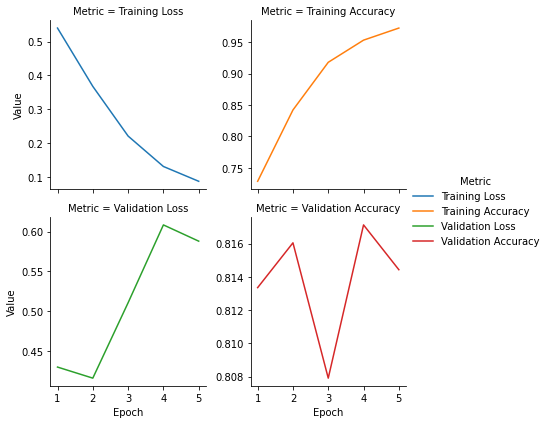

In [21]:
data = {
    'Epoch': range(1, num_epochs+1),
    'Training Loss': train_losses,
    'Training Accuracy': train_accs,
    'Validation Loss': val_losses,
    'Validation Accuracy': val_accs
}

trends = pd.DataFrame(data)

trends = trends.melt(id_vars=['Epoch'], var_name='Metric', value_name='Value')

# Create a facet grid with subplots for each metric
g = sns.FacetGrid(trends, col='Metric', hue='Metric', col_wrap=2, sharey=False)
g.map(sns.lineplot, 'Epoch', 'Value')

# Set the axis labels and legend
g.set_axis_labels('Epoch', 'Value')
g.add_legend()

# Show the plot
plt.show()

In [22]:
torch.save(model.state_dict(), ROOT / "unibs-binary-nofreeze-pooled.pth")

In [23]:
bert_classification = BertForSentimentAnalysis()
bert_classification.load_state_dict(torch.load(ROOT / "unibs-binary-nofreeze-pooled.pth"))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:
bert_classification.to(device)

In [25]:
def predict(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()
    predictions=[]
    # Tracking variables
    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()
        predictions.append(int(preds.detach().cpu().numpy()))

    return predictions

In [26]:
predictions = predict(bert_classification, test_dataloader)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1155
           1       0.79      0.84      0.81      1161

    accuracy                           0.81      2316
   macro avg       0.81      0.81      0.81      2316
weighted avg       0.81      0.81      0.81      2316



# REGRESSION

In [27]:
# REGRESSION TASK
reviews_df = pd.read_csv(ROOT / "regression_reviews.csv")

# First we need to rescale the values from [0,5] to [0,1]
reviews_df['review_score'] = reviews_df['review_score'] / 5.0

In [28]:
# Sample just a portion of the data
# perc = 0.25
# reviews_df = reviews_df.sample(frac=perc, random_state=RANDOM_STATE)

X = reviews_df['review_content'].values
y = reviews_df['review_score'].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

X_train, X_val, y_train, y_val =\
    train_test_split(X_train, y_train, test_size=VALIDATION_SIZE, random_state=RANDOM_STATE)

# Tokenize the input text

max_len = 30

# Run function `preprocessing_for_bert` on the train set, the validation set and the test set
train_inputs, train_masks = preprocessing_for_bert(X_train, max_len)
val_inputs, val_masks = preprocessing_for_bert(X_val, max_len)
test_inputs, test_masks = preprocessing_for_bert(X_test, max_len)

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
test_labels = torch.tensor(y_test)

# For fine-tuning BERT, it's recommended a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=1)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [29]:
class BertForSentimentRegression(nn.Module):
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertForSentimentRegression, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        
        D_in, H, D_out = 768, 100, 1 #The hidden level can be changed to improve the performances!

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.regressor = nn.Sequential(
            nn.Dropout(0.1), #Try to change the dropout value to improve the performances
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, D_out)
        )

        self.double()

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        pooled_output = outputs.pooler_output
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        # last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        regression_output = self.regressor(pooled_output)

        return regression_output.squeeze(-1)

In [30]:
def train(model, train_dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(train_dataloader):
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        # input_ids = batch['input_ids'].to(device)
        # attention_mask = batch['attention_mask'].to(device)
        # labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(train_dataloader)


def evaluate(model, val_dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(val_dataloader):
            input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

            epoch_loss += loss.item()

    return epoch_loss / len(val_dataloader)


In [31]:
model = BertForSentimentRegression(freeze_bert=False)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.MSELoss()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
train_losses = []
val_losses = []

num_epochs = 5

for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader, optimizer, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(train_loss)
    val_loss = evaluate(model, val_dataloader, criterion, device)
    print(f"Epoch {epoch+1}. Train loss: {train_loss:.5f}. Validation loss: {val_loss:.5f}")


Epoch 1. Train loss: 0.08438. Validation loss: 0.05635
Epoch 2. Train loss: 0.04752. Validation loss: 0.05511
Epoch 3. Train loss: 0.03253. Validation loss: 0.05918
Epoch 4. Train loss: 0.02208. Validation loss: 0.05604
Epoch 5. Train loss: 0.01628. Validation loss: 0.05332


In [33]:
torch.save(model.state_dict(), ROOT / "unibs-regression-nofreeze-pooled.pth")

In [34]:
bert_regression = BertForSentimentRegression()
bert_regression.load_state_dict(torch.load(ROOT / "unibs-regression-nofreeze-pooled.pth"))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:
bert_regression.to(device)

In [36]:
def predict(model, test_dataloader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids, attention_mask, _ = tuple(t.to(device) for t in batch)

            outputs = model(input_ids, attention_mask=attention_mask)
            predictions.extend(outputs.tolist())

    return predictions

In [37]:
predictions = predict(model, test_dataloader)
targets = y_test

mse = mean_squared_error(targets, predictions)
rmse = mean_squared_error(targets, predictions, squared=False)
mae = mean_absolute_error(targets, predictions)
r2 = r2_score(targets, predictions)

print(f"MSE: {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAE: {mae:.5f}")
print(f"R2: {r2:.5f}")

MSE: 0.05843
RMSE: 0.24173
MAE: 0.18152
R2: 0.42351


In [38]:
# ============================================== #
# =============== Manual Testing =============== #
# ============================================== #

In [39]:
bert_classification = BertForSentimentAnalysis()
bert_classification.load_state_dict(torch.load(ROOT / "unibs-binary-nofreeze-pooled.pth"))

bert_regression = BertForSentimentRegression()
bert_regression.load_state_dict(torch.load(ROOT / "unibs-regression-nofreeze-pooled.pth"))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.we

<All keys matched successfully>

In [40]:
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download("omw-1.4")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [41]:
def preprocess_text(text):
    # Removing numerical data or irrelevant characters
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Tokenization
    tokens = nltk.word_tokenize(text)
    # Lowercasing
    tokens = [token.lower() for token in tokens]
    # Removing stopwords
    tokens = [token for token in tokens if token not in stopwords.words("english")]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Joining the tokens back to a string
    text = " ".join(tokens)
    return text

In [42]:
def custom_classification_test(model, text):
    inputs = tokenizer(text, return_tensors='pt')
    outputs = model(inputs['input_ids'], inputs['attention_mask'])
    predicted_class = torch.argmax(outputs[0])
    return 'Fresh' if predicted_class == 1 else 'Rotten'

In [43]:
def custom_regression_test(model, text):
    input = tokenizer(text, return_tensors='pt')
    output = model(input['input_ids'], input['attention_mask'])
    return output.item() * 5.0

In [44]:
reviews = pd.read_csv(ROOT / "clean_reviews.csv")
reviews = reviews.sample(50, random_state=RANDOM_STATE+1)

for r in reviews.iterrows():
    _, r = r
    review_type, review_score, review_content = r
    # print(r)eview_type, review_score, review_content = r
    print('REVIEW:')
    print(review_content)

    text = preprocess_text(review_content)

    print('True type:', 'Rotten' if review_type == 0 else 'Fresh')
    print('Predicted type:', custom_classification_test(bert_classification, text))

    print('True score:', review_score)
    print('Predicted score:', custom_regression_test(bert_regression, text))


REVIEW:
Aimless, sloppy, low-budget garbage that will prove especially painful to endure for long-time Kevin Smith fans. Where did all that zeitgeist savvy go?
True type: Rotten
Predicted type: Rotten
True score: 0.5
Predicted score: 0.7563454390599058
REVIEW:
[Washington] has a terrific cast at his disposal.
True type: Fresh
Predicted type: Fresh
True score: 3.0
Predicted score: 3.2764272219320056
REVIEW:
My Cousin Rachel belongs to Weisz, in a role that capitalises on her gift for showing multiple layers of emotion.
True type: Fresh
Predicted type: Fresh
True score: 3.0
Predicted score: 3.2818575735365316
REVIEW:
Some of the phallic jokes work, others are really lame. Fortunately there are many other funny bits that have nothing to do with body parts that keep the laughs coming.
True type: Fresh
Predicted type: Fresh
True score: 3.0
Predicted score: 1.36877654277474
REVIEW:
I think it was after Betty White told Steve Martin's son not to "wear his hair like a ***" that I thought about